In [1]:
%load_ext watermark
%watermark -p torch,lightning,torchmetrics,matplotlib

torch       : 1.12.1
lightning   : 2022.9.8
torchmetrics: 0.9.3
matplotlib  : 3.5.2



# Class distance weighted cross-entropy loss for ordinal regression and deep learning -- cement strength dataset

Implementation of a method for ordinal regression by Polat et al 2022 [1].

**Paper reference:**

- [1] G Polat, I Ergenc, HT Kani, YO Alahdab, O Atug, A Temizel. "[Class Distance Weighted Cross-Entropy Loss for Ulcerative Colitis Severity Estimation](https://arxiv.org/abs/2202.05167)." arXiv preprint arXiv:1612.00775 (2022).

**Note:**
    
To keep the notation lean and minimal, this notebook only contains "Class Distance Weighted Cross-Entropy Loss "-specific comments. For more comments on the PyTorch Lightning use, please see the cross-entropy baseline notebook [baseline-light_cement.ipynb](./baseline-light_cement.ipynb).

## General settings and hyperparameters

In [2]:
BATCH_SIZE = 128
NUM_EPOCHS = 200
LEARNING_RATE = 0.005
NUM_WORKERS = 0

DATA_BASEPATH = "."

## 2 - Implementing the class distance weighted cross-entropy loss

According to the paper, the loss is described as follows:

$$\mathbf{C D WC E}=-\sum_{i=0}^{N-1} \log (1-\hat{y}) \times|i-c|^{\text {power }}$$

where

- $N$: the number of class labels
- $\hat{y}$: the predicted scores
- $c$: ground-truth class
- power: a hyperparameter term that determines the strength of the cost coefficient

In [3]:
import torch
import torch.nn.functional as F

targets = torch.tensor([0, 2, 1, 2])

logits = torch.tensor( [[-0.3,  -0.5, -0.5], # each row is 1 training example
                        [-0.4,  -0.1, -0.5],
                        [-0.3,  -0.94, -0.5],
                        [-0.99, -0.88, -0.5]])

probas = F.softmax(logits, dim=1)
probas

tensor([[0.3792, 0.3104, 0.3104],
        [0.3072, 0.4147, 0.2780],
        [0.4263, 0.2248, 0.3490],
        [0.2668, 0.2978, 0.4354]])

In [4]:
def cdw_ce_loss_naive1(probas, targets, power=5):
    
    loss = torch.zeros(probas.shape[0])
    for example in range(probas.shape[0]):
        for i in range(probas.shape[1]):
            loss[example] += -torch.log(1-probas[example, i]) * torch.abs(i - targets[example])**power
    
    return loss
        
cdw_ce_loss_naive1(probas, targets)

tensor([12.2654, 12.2824,  0.9848, 10.2828])

In [5]:
%timeit cdw_ce_loss_naive1(probas, targets)

147 µs ± 2.64 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [6]:
def cdw_ce_loss_naive2(probas, targets, power=5):
    
    loss = 0.
    for i in range(probas.shape[1]):
        loss += (-torch.log(1-probas[:, i]) * torch.abs(i - targets)**power)
        
    return loss
        
cdw_ce_loss_naive2(probas, targets)

tensor([12.2654, 12.2824,  0.9848, 10.2828])

In [7]:
%timeit cdw_ce_loss_naive2(probas, targets)

33.6 µs ± 82.6 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [8]:
def cdw_ce_loss_naive3(probas, targets, power=5):
    
    labels = torch.arange(probas.shape[1]).repeat(probas.shape[0], 1)
    loss = (-torch.log(1-probas) * torch.abs(labels - targets.reshape(probas.shape[0], 1))**power).sum(dim=1)
        
    return loss
        
cdw_ce_loss_naive3(probas, targets)

tensor([12.2654, 12.2824,  0.9848, 10.2828])

In [9]:
%timeit cdw_ce_loss_naive3(probas, targets)

14.6 µs ± 61.4 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [10]:
def cdw_ce_loss(logits, targets, power=5, reduction="mean"):
    
    probas = torch.softmax(logits, dim=1)
    labels = torch.arange(probas.shape[1]).repeat(probas.shape[0], 1).type_as(logits)
    loss = (-torch.log(1-probas) * torch.abs(labels - targets.type_as(labels).\
                                             reshape(probas.shape[0], 1))**power).sum(dim=1)
        
    if reduction == "none":
        return loss
    elif reduction == "sum":
        return loss.sum()
    elif reduction == "mean":
        return loss.mean()    
    else:
        raise ValueError("reduction must be 'none', 'sum', or 'mean'")    

cdw_ce_loss(logits, targets)

tensor(8.9538)

## Implementing a `MultiLayerPerceptron` using PyTorch Lightning's `LightningModule`

In [11]:
import torch


class MultiLayerPerceptron(torch.nn.Module):
    def __init__(self, input_size, hidden_units, num_classes):
        super().__init__()

        self.num_classes = num_classes
        
        all_layers = []
        for hidden_unit in hidden_units:
            layer = torch.nn.Linear(input_size, hidden_unit)
            all_layers.append(layer)
            all_layers.append(torch.nn.ReLU())
            input_size = hidden_unit

        output_layer = torch.nn.Linear(hidden_units[-1], num_classes)
        
        all_layers.append(output_layer)
        self.model = torch.nn.Sequential(*all_layers) 
        
    def forward(self, x):
        x = self.model(x)
        return x

And then, we will use them below in the `LightningModule`. They are only used in the `_shared_step` method as indicated:

In [12]:
import lightning as L
import torchmetrics


class LightningMLP(L.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()

        self.learning_rate = learning_rate
        self.model = model

        self.save_hyperparameters(ignore=['model'])

        self.train_mae = torchmetrics.MeanAbsoluteError()
        self.valid_mae = torchmetrics.MeanAbsoluteError()
        self.test_mae = torchmetrics.MeanAbsoluteError()
        
    def forward(self, x):
        return self.model(x)

    def _shared_step(self, batch):
        features, true_labels = batch
        logits = self(features)

        loss = cdw_ce_loss(logits, true_labels)
        predicted_labels = torch.argmax(logits, dim=1)
        
        return loss, true_labels, predicted_labels

    def training_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.log("train_loss", loss)
        self.train_mae(predicted_labels.float(), true_labels.float())
        self.log("train_mae", self.train_mae, on_epoch=True, on_step=False)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.log("valid_loss", loss)
        self.valid_mae(predicted_labels.float(), true_labels.float())
        self.log("valid_mae", self.valid_mae,
                 on_epoch=True, on_step=False, prog_bar=True)

    def test_step(self, batch, batch_idx):
        loss, true_labels, predicted_labels = self._shared_step(batch)
        self.test_mae(predicted_labels.float(), true_labels.float())
        self.log("test_mae", self.test_mae, on_epoch=True, on_step=False)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

---

# Note: There Are No Changes Compared To The Baseline Below

---

## Setting up the dataset

### Inspecting the dataset

In [13]:
import pandas as pd
import numpy as np


data_df = pd.read_csv("https://raw.githubusercontent.com/gagolews/"
                      "ordinal_regression_data/master/cement_strength.csv")
data_df["response"] = data_df["response"]-1

data_labels = data_df["response"]
data_features = data_df.loc[:, [
    "V1", "V2", "V3", "V4", "V5", "V6", "V7", "V8"]]

data_df.head()

,response,V1,V2,V3,V4,V5,V6,V7,V8
0,4,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28
1,4,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28
2,2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270
3,2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365
4,2,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360


In [14]:
print('Number of features:', data_features.shape[1])
print('Number of examples:', data_features.shape[0])
print('Labels:', np.unique(data_labels.values))
print('Label distribution:', np.bincount(data_labels))

Number of features: 8
Number of examples: 998
Labels: [0 1 2 3 4]
Label distribution: [196 310 244 152  96]


### Performance baseline

In [15]:
avg_prediction = np.median(data_labels.values)  # median minimizes MAE
baseline_mae = np.mean(np.abs(data_labels.values - avg_prediction))
print(f'Baseline MAE: {baseline_mae:.2f}')

Baseline MAE: 1.03


### Creating a `Dataset` class

In [16]:
from torch.utils.data import Dataset


class MyDataset(Dataset):

    def __init__(self, feature_array, label_array, dtype=np.float32):
        self.features = feature_array.astype(dtype)
        self.labels = label_array

    def __getitem__(self, index):
        inputs = self.features[index]
        label = self.labels[index]
        return inputs, label

    def __len__(self):
        return self.features.shape[0]

### Setting up a `DataModule`

In [17]:
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader


class DataModule(L.LightningDataModule):
    def __init__(self, data_path='./'):
        super().__init__()
        self.data_path = data_path
        
    def prepare_data(self):
        data_df = pd.read_csv(
            'https://raw.githubusercontent.com/gagolews/'
            'ordinal_regression_data/master/cement_strength.csv')
        data_df.to_csv(
            os.path.join(self.data_path, 'cement_strength.csv'), index=None)
        return

    def setup(self, stage=None):
        data_df = pd.read_csv(
            os.path.join(self.data_path, 'cement_strength.csv'))
        data_df["response"] = data_df["response"]-1  # labels should start at 0
        self.data_labels = data_df["response"]
        self.data_features = data_df.loc[:, [
            "V1", "V2", "V3", "V4", "V5", "V6", "V7", "V8"]]
        
        # Split into
        # 70% train, 10% validation, 20% testing
        
        X_temp, X_test, y_temp, y_test = train_test_split(
            self.data_features.values,
            self.data_labels.values,
            test_size=0.2,
            random_state=1,
            stratify=self.data_labels.values)

        X_train, X_valid, y_train, y_valid = train_test_split(
            X_temp,
            y_temp,
            test_size=0.1,
            random_state=1,
            stratify=y_temp)
        
        # Standardize features
        sc = StandardScaler()
        X_train_std = sc.fit_transform(X_train)
        X_valid_std = sc.transform(X_valid)
        X_test_std = sc.transform(X_test)

        self.train = MyDataset(X_train_std, y_train)
        self.valid = MyDataset(X_valid_std, y_valid)
        self.test = MyDataset(X_test_std, y_test)

    def train_dataloader(self):
        return DataLoader(self.train, batch_size=BATCH_SIZE,
                          num_workers=NUM_WORKERS,
                          drop_last=True)

    def val_dataloader(self):
        return DataLoader(self.valid, batch_size=BATCH_SIZE,
                          num_workers=NUM_WORKERS)

    def test_dataloader(self):
        return DataLoader(self.test, batch_size=BATCH_SIZE,
                          num_workers=NUM_WORKERS)

/Users/sebastianraschka/miniforge3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [18]:
torch.manual_seed(1) 
data_module = DataModule(data_path=DATA_BASEPATH)

## Training the model using the PyTorch Lightning Trainer class

In [19]:
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger


pytorch_model = MultiLayerPerceptron(
    input_size=data_features.shape[1],
    hidden_units=(40, 20),
    num_classes=np.bincount(data_labels).shape[0])

lightning_model = LightningMLP(
    model=pytorch_model,
    learning_rate=LEARNING_RATE)


callbacks = [ModelCheckpoint(
    save_top_k=1, mode="min", monitor="valid_mae")]  # save top 1 model 
logger = CSVLogger(save_dir="logs/", name="mlp-beckham-cement")

In [20]:
import time


trainer = L.Trainer(
    max_epochs=NUM_EPOCHS,
    callbacks=callbacks,
    accelerator="cpu",  # Uses Apple Silicon, GPUs or TPUs if available
    devices="auto",  # Uses all available GPUs/TPUs if applicable
    logger=logger,
    deterministic=True,
    log_every_n_steps=10)

start_time = time.time()
trainer.fit(model=lightning_model, datamodule=data_module)

runtime = (time.time() - start_time)/60
print(f"Training took {runtime:.2f} min in total.")

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/sebastianraschka/miniforge3/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1791: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name      | Type                 | Params
---------------------------------------------------
0 | model     | MultiLayerPerceptron | 1.3 K 
1 | train_mae | MeanAbsoluteError    | 0     
2 | valid_mae | MeanAbsoluteError    | 0     
3 | test_mae  | MeanAbsoluteError    | 0     
---------------------------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/sebastianraschka/miniforge3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:219: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/sebastianraschka/miniforge3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:219: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/sebastianraschka/miniforge3/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1894: PossibleUserWarning: The number of training batches (5) is smaller t

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Training took 0.13 min in total.


## Evaluating the model

<AxesSubplot:xlabel='Epoch', ylabel='MAE'>

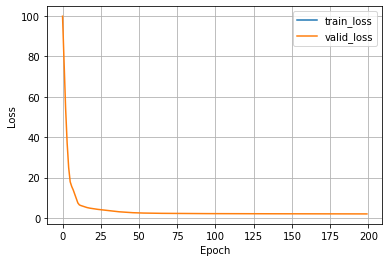

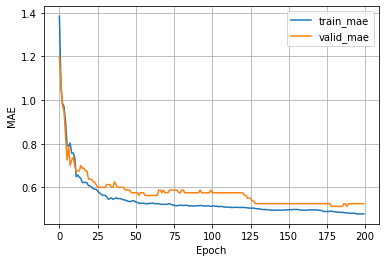

In [21]:
metrics = pd.read_csv(f"{trainer.logger.log_dir}/metrics.csv")

aggreg_metrics = []
agg_col = "epoch"
for i, dfg in metrics.groupby(agg_col):
    agg = dict(dfg.mean())
    agg[agg_col] = i
    aggreg_metrics.append(agg)

df_metrics = pd.DataFrame(aggreg_metrics)
df_metrics[["train_loss", "valid_loss"]].plot(
    grid=True, legend=True, xlabel='Epoch', ylabel='Loss')
df_metrics[["train_mae", "valid_mae"]].plot(
    grid=True, legend=True, xlabel='Epoch', ylabel='MAE')

In [22]:
trainer.test(model=lightning_model, datamodule=data_module, ckpt_path='best')

Restoring states from the checkpoint path at logs/mlp-beckham-cement/version_16/checkpoints/epoch=178-step=895.ckpt
Loaded model weights from checkpoint at logs/mlp-beckham-cement/version_16/checkpoints/epoch=178-step=895.ckpt
/Users/sebastianraschka/miniforge3/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:219: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_mae          │    0.5199999809265137     │
└───────────────────────────┴───────────────────────────┘

[{'test_mae': 0.5199999809265137}]